In [ ]:
import pandas as pd
import numpy as np
import re
import ast  # Use ast.literal_eval for safer parsing than eval
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore', category=FutureWarning) # Suppress specific pandas warning about iteritems

# --- Configuration ---
N_TOP_TAGS = 50 # Number of most frequent tags to one-hot encode
DATA_SUBSET_SIZE = None # Set to None to use full dataset

# --- 1. Load Data ---
print("Loading data...")
try:
    data_interactions = pd.read_csv('data/RAW_interactions.csv')
    data_recipes = pd.read_csv('data/RAW_recipes.csv')
except FileNotFoundError:
    print("Error: Ensure 'data/RAW_interactions.csv' and 'data/RAW_recipes.csv' are in the correct directory.")
    # Exit or handle error appropriately
    exit()

print(f"Loaded {len(data_recipes)} recipes and {len(data_interactions)} interactions.")

# --- Subsetting ---
if DATA_SUBSET_SIZE is not None:
    print(f"Subsetting data to first {DATA_SUBSET_SIZE} recipes...")
    # Get the IDs of the first N recipes
    subset_recipe_ids = data_recipes['id'].iloc[:DATA_SUBSET_SIZE].tolist()
    # Filter both dataframes
    data_recipes = data_recipes[data_recipes['id'].isin(subset_recipe_ids)].copy()
    data_interactions = data_interactions[data_interactions['recipe_id'].isin(subset_recipe_ids)].copy()
    print(f"Using {len(data_recipes)} recipes and {len(data_interactions)} interactions after subsetting.")


# --- 2. Calculate Average Rating ---
print("Calculating average ratings...")
# Handle potential non-numeric ratings if necessary, though the dataset seems clean here
data_interactions['rating'] = pd.to_numeric(data_interactions['rating'], errors='coerce')
data_interactions.dropna(subset=['rating'], inplace=True)

avg_rating = data_interactions.groupby('recipe_id')['rating'].mean().reset_index()
avg_rating.columns = ['id', 'avg_rating']

# Merge with recipes data
recipes_df = data_recipes.merge(avg_rating, on='id', how='left') # Use left join to keep all recipes, even if unrated
# Drop recipes with no interactions/ratings if required (original code did dropna)
recipes_df.dropna(subset=['avg_rating'], inplace=True)
print(f"{len(recipes_df)} recipes remaining after merging ratings and dropping NaNs.")

# --- 3. Combine Text ---
print("Combining name and description...")
recipes_df['name'] = recipes_df['name'].fillna('')
recipes_df['description'] = recipes_df['description'].fillna('')
recipes_df['combined_text'] = recipes_df['name'] + ' ' + recipes_df['description']

# --- 4. Clean Text for LSTM ---
print("Cleaning text for LSTM...")

# Define the cleaning components (as used in the original LSTMAutoencoder script)
measures = ['teaspoon', 't','tsp','tablespoon','T','tbsp','cup','c','pint','p','quart','q','gallon','g','oz','ounce','fl','fluid','lb','pound','mg','milligram','gram','kg','kilogram']
words_to_remove = ['fresh', 'oil', 'a','red','bunch','green','white','black','yellow','large','small','medium','diced','chopped','sliced','minced','crushed','grated','peeled','seeded','cooked','uncooked','whole','halved','quartered','cubed','shredded','drained','rinsed','trimmed','divided','beaten','softened','melted','packed','dried','to','taste','for','serving','optional','as','needed','and','more','or','less','cut','into','strips','lengthwise','crosswise','thinly','thickly','sliced','canned','frozen','thawed','at','room','temperature','temp']
remove_set = set(measures + words_to_remove).union(ENGLISH_STOP_WORDS)

def clean_text_for_lstm(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text) # Keep only letters and spaces
    tokens = text.split()
    cleaned_tokens = [t for t in tokens if t not in remove_set and len(t) > 1] # Also remove single letters
    return " ".join(cleaned_tokens) # Join back into a single string

# Apply cleaning using tqdm for progress
tqdm.pandas(desc="Cleaning Text")
recipes_df['cleaned_text_for_lstm'] = recipes_df['combined_text'].progress_apply(clean_text_for_lstm)

# --- 5. Extract Numeric Features ---
print("Extracting numeric features...")
numeric_features = ['minutes', 'n_steps', 'n_ingredients']
# Basic NaN handling: fill with median
for col in numeric_features:
    median_val = recipes_df[col].median()
    recipes_df[col].fillna(median_val, inplace=True)
    q_low = recipes_df[col].quantile(0.01)
    q_high = recipes_df[col].quantile(0.99)
    recipes_df[col] = recipes_df[col].clip(q_low, q_high)


# --- 6. Extract Nutrition Features ---
print("Extracting nutrition features...")
# Expected order: [calories, total fat (% daily value), sugar (% dv), sodium (% dv), protein (% dv), saturated fat (% dv), carbohydrates (% dv)]
nutrition_cols = ['calories', 'total_fat_pdv', 'sugar_pdv', 'sodium_pdv', 'protein_pdv', 'saturated_fat_pdv', 'carbohydrates_pdv']

def parse_nutrition(nutrition_str):
    try:
        # Use ast.literal_eval for safety
        nutr_list = ast.literal_eval(nutrition_str)
        if isinstance(nutr_list, list) and len(nutr_list) == len(nutrition_cols):
            return pd.Series(nutr_list, index=nutrition_cols)
        else:
            # Return NaNs if format is unexpected
            return pd.Series([np.nan] * len(nutrition_cols), index=nutrition_cols)
    except (ValueError, SyntaxError, TypeError):
        # Handle cases where parsing fails or input is not string/list
         return pd.Series([np.nan] * len(nutrition_cols), index=nutrition_cols)

# Apply parsing
nutrition_df = recipes_df['nutrition'].apply(parse_nutrition)

# Join back with main df
recipes_df = pd.concat([recipes_df, nutrition_df], axis=1)

# Handle potential NaNs introduced during parsing (fill with median)
for col in nutrition_cols:
    median_val = recipes_df[col].median()
    recipes_df[col].fillna(median_val, inplace=True)

# --- 7. Extract Date Features ---
print("Extracting date features...")
recipes_df['submitted'] = pd.to_datetime(recipes_df['submitted'], errors='coerce')
recipes_df['submission_year'] = recipes_df['submitted'].dt.year
recipes_df['submission_month'] = recipes_df['submitted'].dt.month
# Fill NaNs for year/month (e.g., with median year/month if any failed conversion)
recipes_df['submission_year'].fillna(recipes_df['submission_year'].median(), inplace=True)
recipes_df['submission_month'].fillna(recipes_df['submission_month'].median(), inplace=True)


# --- 8. Process Tags ---
print(f"Processing tags (one-hot encoding top {N_TOP_TAGS})...")

def parse_tags(tags_str):
    try:
        tags_list = ast.literal_eval(tags_str)
        if isinstance(tags_list, list):
            return tags_list
        else:
            return []
    except (ValueError, SyntaxError, TypeError):
        return []

recipes_df['tags_list'] = recipes_df['tags'].apply(parse_tags)

# Count all tags
all_tags = Counter(tag for tags in recipes_df['tags_list'] for tag in tags)
print(f"Found {len(all_tags)} unique tags.")

# Get the most common tags
top_tags = [tag for tag, count in all_tags.most_common(N_TOP_TAGS)]
print(f"Top {N_TOP_TAGS} tags: {top_tags[:10]}...") # Print first few

# Create binary columns for top tags
for tag in tqdm(top_tags, desc="Creating Tag Columns"):
    col_name = f'tag_{re.sub(r"[^a-z0-9_]+", "_", tag.lower())}' # Sanitize tag name for column
    recipes_df[col_name] = recipes_df['tags_list'].apply(lambda x: 1 if tag in x else 0)

# --- 10. Select Final Columns ---
print("Selecting final columns...")

# Define column groups
id_col = ['id']
target_col = ['avg_rating']
lstm_text_col = ['cleaned_text_for_lstm']
base_numeric_cols = numeric_features # ['minutes', 'n_steps', 'n_ingredients']
nutrition_numeric_cols = nutrition_cols
date_numeric_cols = ['submission_year', 'submission_month']
tag_categorical_cols = [f'tag_{re.sub(r"[^a-z0-9_]+", "_", tag.lower())}' for tag in top_tags]

# Combine all desired columns
final_columns = id_col + target_col + lstm_text_col + base_numeric_cols + nutrition_numeric_cols + date_numeric_cols + tag_categorical_cols # + other_cols

# Create the final DataFrame
processed_df = recipes_df[final_columns].copy()

# Drop rows where cleaning might have failed excessively
processed_df = processed_df[processed_df['cleaned_text_for_lstm'] != ""]

print("\nPreprocessing Complete. Final DataFrame Info:")
processed_df.info()
print("\nFinal DataFrame Head:")
print(processed_df.head())
print(f"\nShape of final DataFrame: {processed_df.shape}")

# --- Save the processed DataFrame ---
output_filename = 'data/processed_recipes.csv'
print(f"\nSaving processed data to {output_filename}...")
processed_df.to_csv(output_filename, index=False)
print("Done.")

Loading data...
Loaded 231637 recipes and 1132367 interactions.
Calculating average ratings...
231637 recipes remaining after merging ratings and dropping NaNs.
Combining name and description...
Cleaning text for LSTM...


Cleaning Text: 100%|██████████| 231637/231637 [00:02<00:00, 96714.63it/s]


Extracting numeric features...
Extracting nutrition features...
Extracting date features...
Processing tags (one-hot encoding top 50)...
Found 552 unique tags.
Top 50 tags: ['preparation', 'time-to-make', 'course', 'main-ingredient', 'dietary', 'easy', 'occasion', 'cuisine', 'low-in-something', 'main-dish']...


Creating Tag Columns: 100%|██████████| 50/50 [00:04<00:00, 10.34it/s]


Selecting final columns...

Preprocessing Complete. Final DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 231636 entries, 0 to 231636
Data columns (total 65 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         231636 non-null  int64  
 1   avg_rating                 231636 non-null  float64
 2   cleaned_text_for_lstm      231636 non-null  object 
 3   minutes                    231636 non-null  float64
 4   n_steps                    231636 non-null  int64  
 5   n_ingredients              231636 non-null  int64  
 6   calories                   231636 non-null  float64
 7   total_fat_pdv              231636 non-null  float64
 8   sugar_pdv                  231636 non-null  float64
 9   sodium_pdv                 231636 non-null  float64
 10  protein_pdv                231636 non-null  float64
 11  saturated_fat_pdv          231636 non-null  float64
 12  carbohydrates_pdv

Loading raw data...
Loaded 231637 raw recipes and 1132367 raw interactions.

Preparing data subset...
Selecting subset of 100000 recipes...
Cleaning ingredients...


Cleaning Ingredients: 100%|██████████| 97842/97842 [00:03<00:00, 24698.84it/s]


Creating combined text including ingredients...
Prepared DataFrame with 97842 recipes after cleaning and combining.

Using device: cuda
Loading Sentence Transformer model: all-MiniLM-L6-v2...
Generating embeddings including ingredients (this might take a while)...


Batches:   0%|          | 0/765 [00:00<?, ?it/s]

Embedding generation finished in 49.70 seconds.
Shape of Sentence Transformer embeddings: (97842, 384)

Performing PCA on new SBERT embeddings...
Shape of PCA reduced SBERT embeddings: (97842, 10)
Variance explained by first 2 PCA components: 0.1153

Performing t-SNE on new SBERT embeddings...
Dataset size (97842) > threshold (50000). Sampling 30000 points.
Running t-SNE on 30000 samples.
t-SNE finished in 128.19 seconds.
Shape of t-SNE reduced embeddings: (30000, 2)

Parsing tags...

Cuisine tag counts:
- italian: 3105
- mexican: 2878
- japanese: 360
- chinese: 815
- indian: 1140
- french: 925
- thai: 520

Generating PCA plots (Embeddings with Ingredients)...


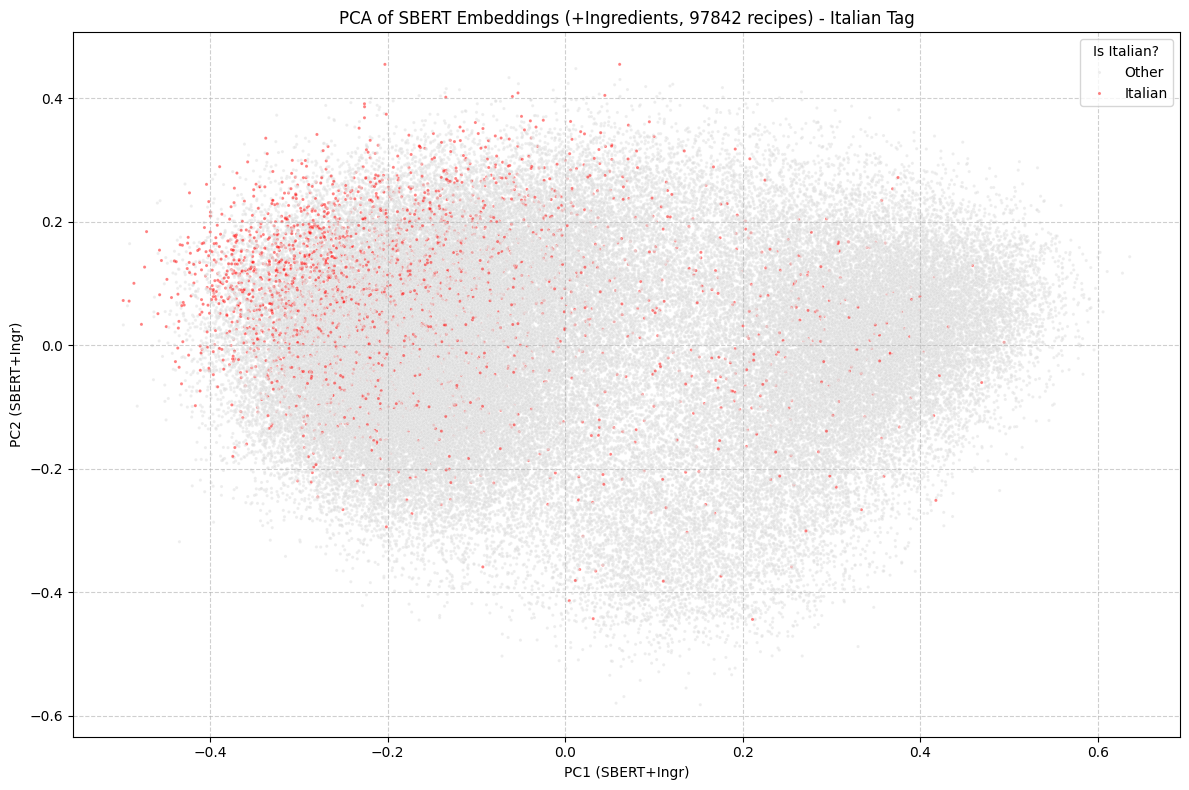

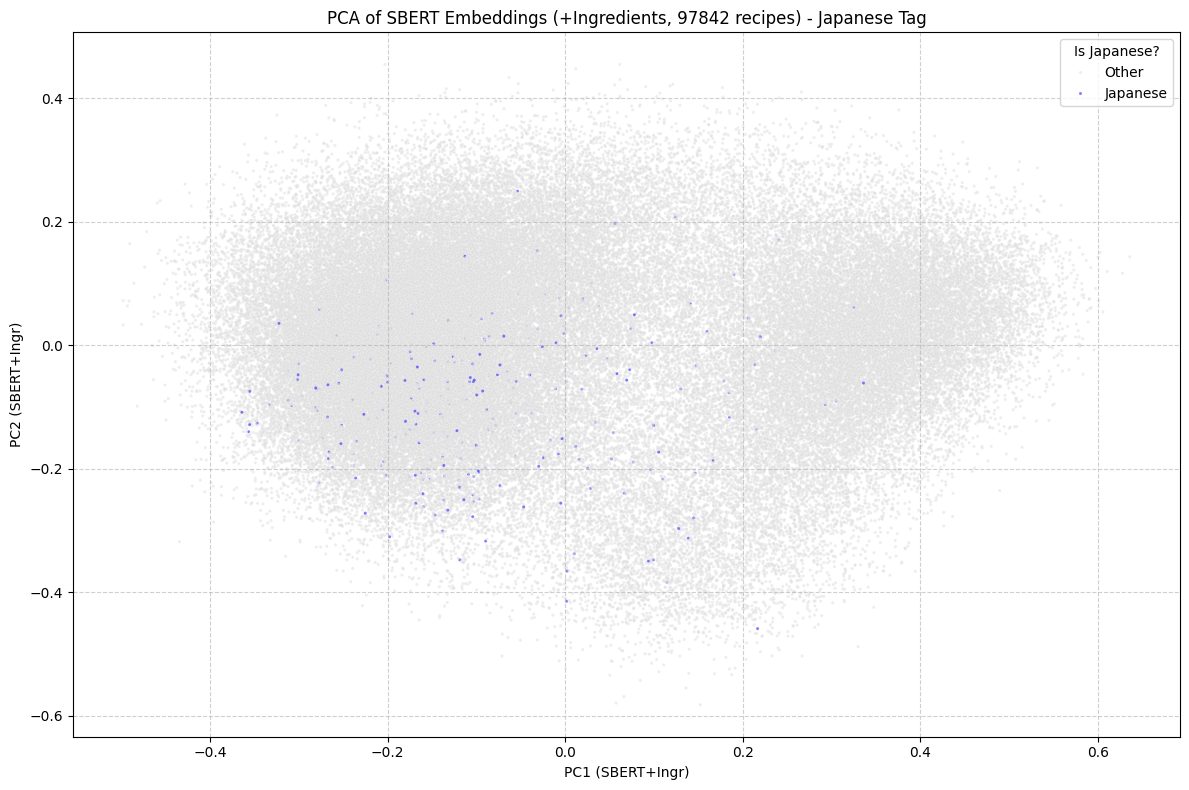

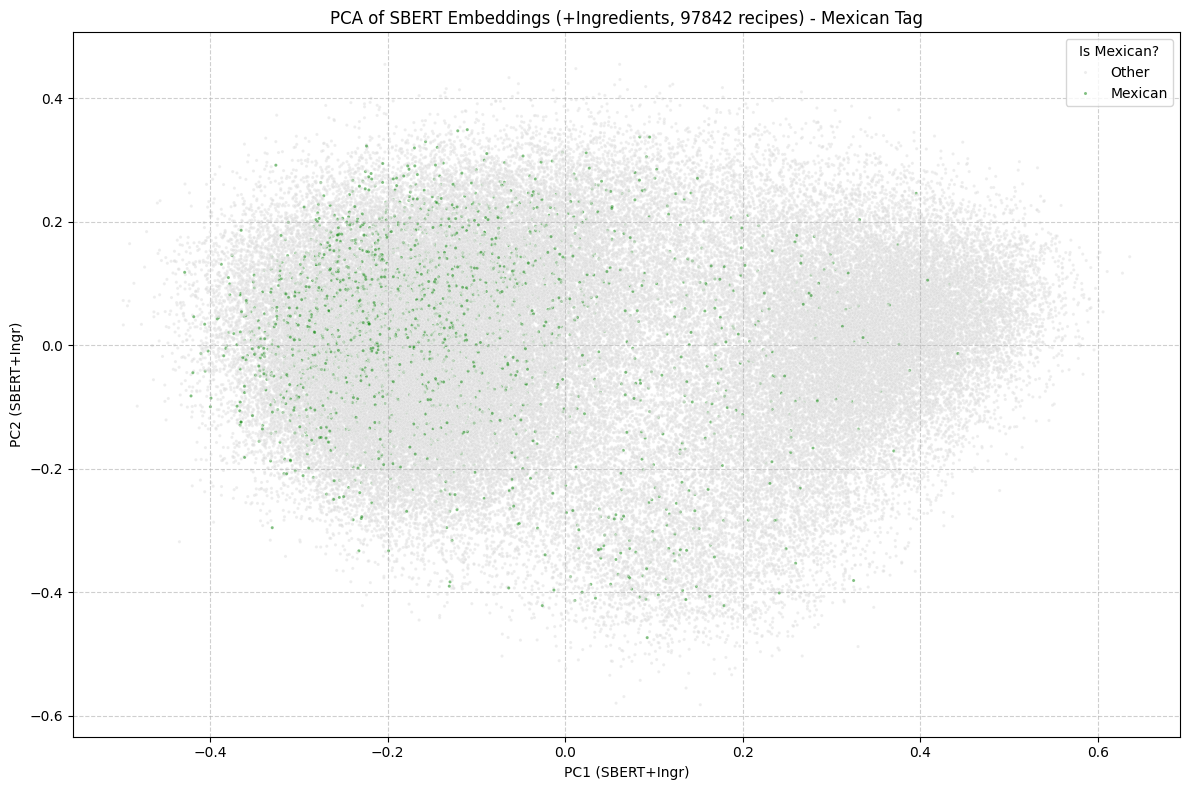


Generating t-SNE plots (Embeddings with Ingredients)...


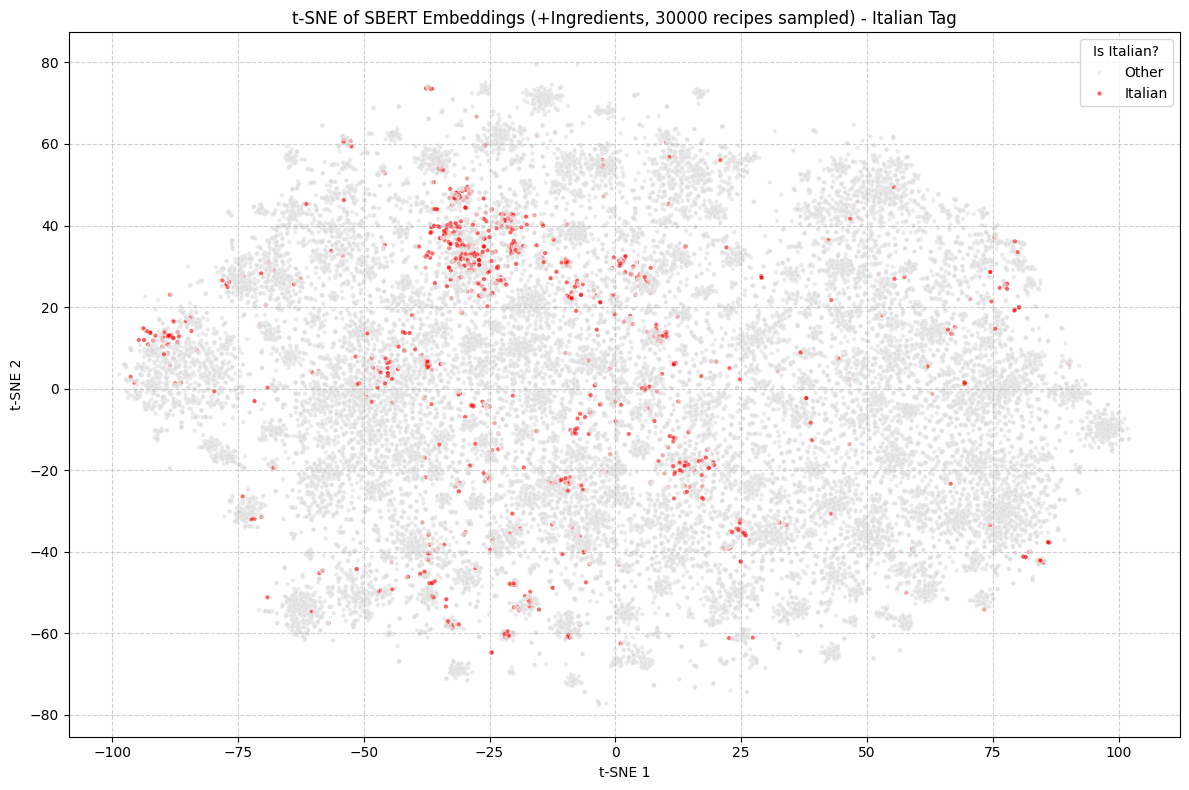

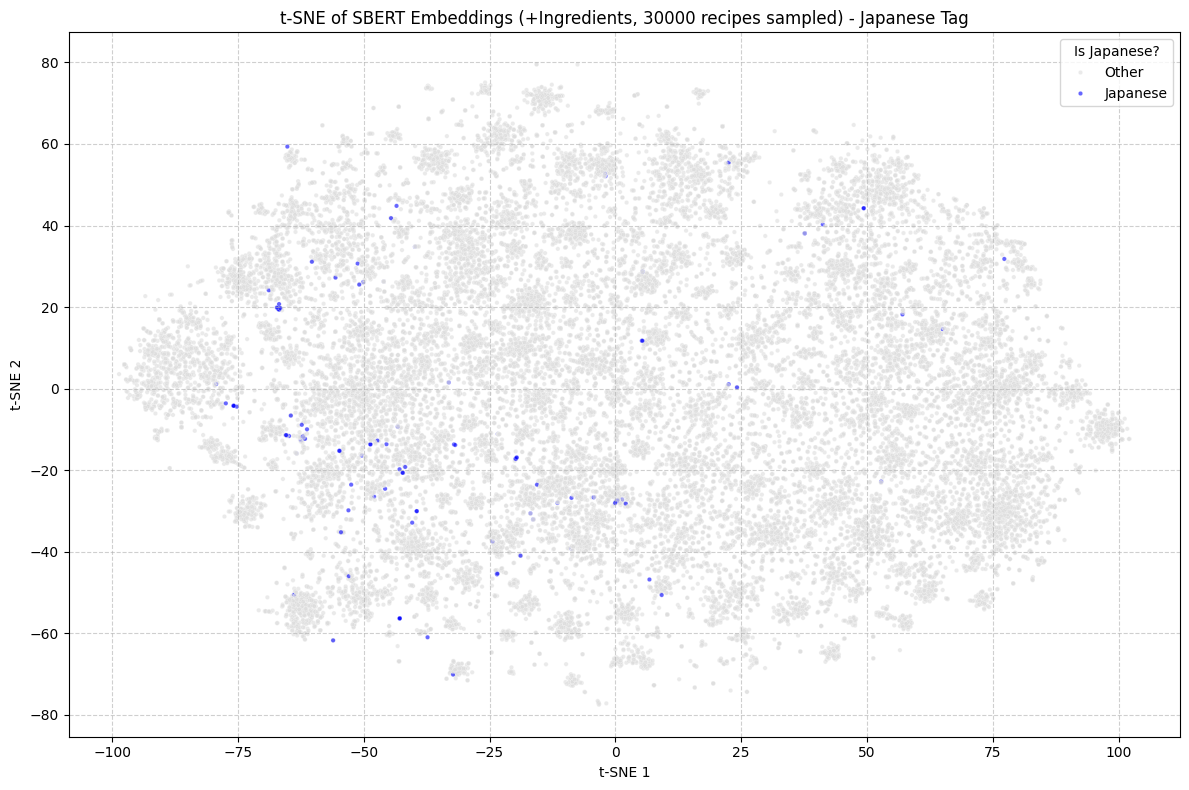

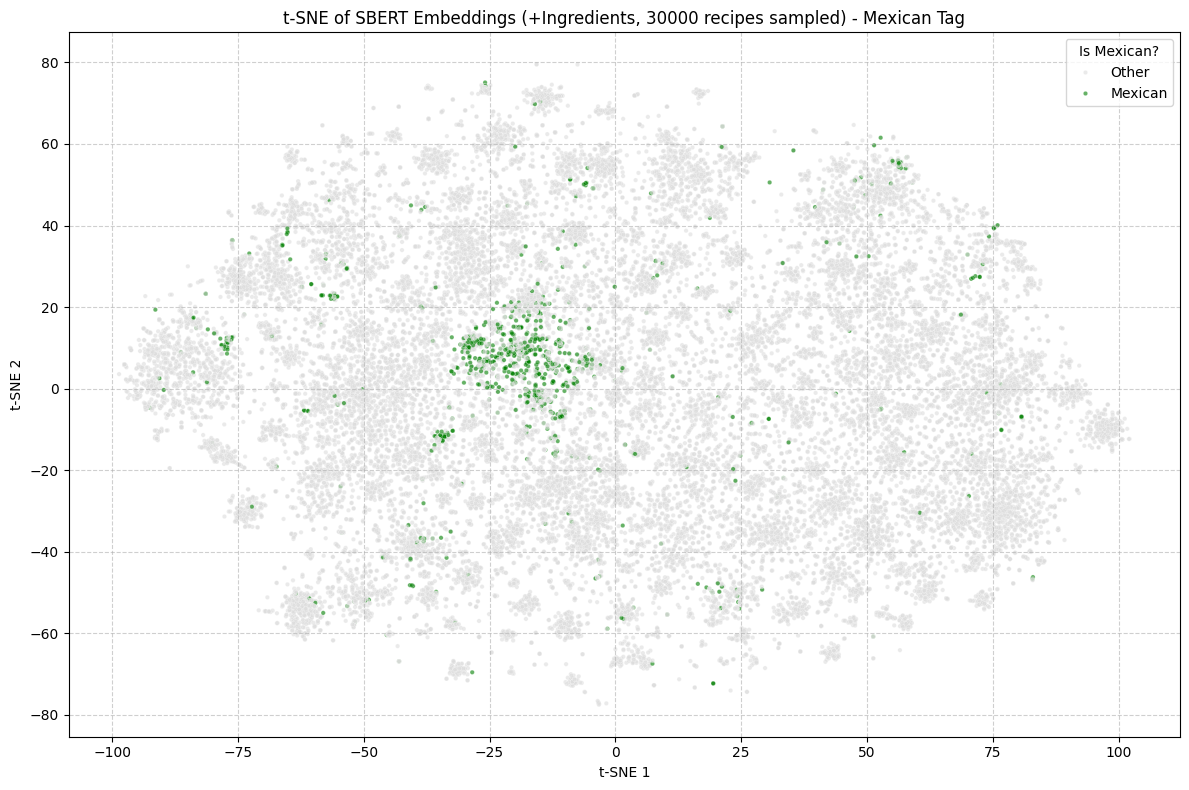


Visualization complete.


In [ ]:
# filename: sbert_ingredients_visualization.ipynb

# --- Imports ---
import pandas as pd
import numpy as np
import re
import ast # For safely evaluating string lists
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS # For ingredient cleaning
from tqdm import tqdm
import warnings
import time
import torch # For device checking

# Sentence Transformers library
try:
    from sentence_transformers import SentenceTransformer
except ImportError:
    print("Sentence Transformers library not found.")
    print("Please install it: pip install sentence-transformers")
    exit()

# Suppress warnings if desired
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)


# --- Configuration ---
# Set to a number (e.g., 100000) or None for full dataset
DATA_SUBSET_SIZE = None
# DATA_SUBSET_SIZE = None # Uncomment to use all rated recipes (longer run time)

SBERT_MODEL_NAME = 'all-MiniLM-L6-v2' # Fast and good quality

# t-SNE settings
RUN_TSNE = True
TSNE_SAMPLE_THRESHOLD = 100000
TSNE_SAMPLE_SIZE = 60000


# --- Ingredient Cleaning Setup ---
# Define words/units to remove from ingredients (can be adjusted)
MEASURES_UNITS = set([
    'teaspoon', 't','tsp','tablespoon','T','tbsp','cup','c','pint','p','quart','q','gallon','g',
    'oz','ounce','fl','fluid','lb','pound','mg','milligram','gram','kg','kilogram', 'liter', 'l', 'ml',
    'cc', 'pinch', 'dash', 'smidgen', 'drop', 'package', 'pkg', 'box', 'can', 'jar', 'bottle',
    'bunch', 'head', 'clove', 'stalk', 'sprig', 'slice', 'piece', 'stick', 'container', 'envelope',
    'scoop', 'bulb', 'sheet', 'segment', 'square', 'fillet', 'strip', 'inch', 'cm', 'mm',
    'degree', 'f', 'fahrenheit', 'celsius', 'x', 'plus'
])

PREP_WORDS = set([
    'fresh', 'freshly', 'oil', 'red', 'green', 'white', 'black', 'yellow', 'purple', 'orange', 'brown',
    'large', 'small', 'medium', 'mini', 'jumbo',
    'diced', 'chopped', 'sliced', 'minced', 'crushed', 'grated', 'peeled', 'seeded', 'cored', 'halved',
    'quartered', 'cubed', 'shredded', 'julienned', 'finely', 'roughly', 'coarsely',
    'cooked', 'uncooked', 'raw', 'boiled', 'steamed', 'roasted', 'fried', 'baked', 'grilled', 'broiled',
    'drained', 'rinsed', 'trimmed', 'pitted', 'divided', 'beaten', 'softened', 'melted', 'packed',
    'dried', 'dry', 'canned', 'frozen', 'thawed', 'instant', 'quickcooking', 'prepared',
    'optional', 'needed', 'taste', 'more', 'less', 'cut', 'into', 'room', 'temperature', 'temp',
    'about', 'approximately', 'or', 'and', 'such', 'as', 'preferably', 'quality', 'good', 'purpose',
    'lengthwise', 'crosswise', 'thinly', 'thickly', 'warm', 'cold', 'hot'
])

INGREDIENT_REMOVE_SET = MEASURES_UNITS.union(PREP_WORDS).union(ENGLISH_STOP_WORDS)

# --- Function to Clean Ingredients ---
def clean_ingredients_text(ingredients_str):
    """
    Cleans a string representation of a list of ingredients.
    Returns a single string of cleaned ingredient names.
    """
    if not isinstance(ingredients_str, str) or not ingredients_str.startswith('['):
        return "" # Handle NaNs or already processed data

    try:
        ingredients_list = ast.literal_eval(ingredients_str)
        if not isinstance(ingredients_list, list):
            return ""
    except (ValueError, SyntaxError):
        return "" # Parsing failed

    cleaned_list = []
    for ing in ingredients_list:
        if not isinstance(ing, str): continue # Skip non-string items in list

        # Basic cleaning
        text = ing.lower()
        text = re.sub(r'\([^)]*\)', '', text) # Remove content in parentheses
        text = re.sub(r"[^a-z\s'-]", "", text) # Keep letters, spaces, hyphens, apostrophes
        text = text.replace('-', ' ') # Replace hyphens with space

        # Tokenize and remove unwanted words
        tokens = text.split()
        cleaned_tokens = [
            token for token in tokens
            if token not in INGREDIENT_REMOVE_SET and len(token) > 1 and not token.isdigit()
        ]

        if cleaned_tokens:
            # Join individual ingredient tokens, handling potential multi-word ingredients
             cleaned_list.append(" ".join(cleaned_tokens))

    # Join all cleaned ingredients for the recipe into one string
    return " ".join(cleaned_list)


# --- 1. Load Raw Data (including ingredients) ---
print("Loading raw data...")
try:
    data_recipes_raw = pd.read_csv('data/RAW_recipes.csv', usecols=['id', 'tags', 'name', 'description', 'ingredients']) # Added 'ingredients'
    data_interactions_raw = pd.read_csv('data/RAW_interactions.csv', usecols=['recipe_id', 'rating'])
except FileNotFoundError:
    print("Error: Raw data CSV files not found.")
    exit()
print(f"Loaded {len(data_recipes_raw)} raw recipes and {len(data_interactions_raw)} raw interactions.")


# --- 2. Prepare Data (with Ingredient Cleaning) ---
print("\nPreparing data subset...")
avg_rating = data_interactions_raw.groupby('recipe_id')['rating'].mean().reset_index()
avg_rating.columns = ['id', 'avg_rating']
recipes_merged = data_recipes_raw.merge(avg_rating, on='id', how='inner')

if DATA_SUBSET_SIZE is not None and DATA_SUBSET_SIZE < len(recipes_merged):
    print(f"Selecting subset of {DATA_SUBSET_SIZE} recipes...")
    recipes_df = recipes_merged.sample(n=DATA_SUBSET_SIZE, random_state=42).copy()
else:
    print("Using all rated recipes...")
    recipes_df = recipes_merged.copy()

# Handle potential NaNs before creating combined text
recipes_df.dropna(subset=['name', 'description', 'tags', 'ingredients'], inplace=True) # Added ingredients
recipes_df['name'] = recipes_df['name'].fillna('')
recipes_df['description'] = recipes_df['description'].fillna('')
recipes_df['tags'] = recipes_df['tags'].fillna('[]')
recipes_df['ingredients'] = recipes_df['ingredients'].fillna('[]') # Fill NaN ingredients

# Clean Ingredients
print("Cleaning ingredients...")
tqdm.pandas(desc="Cleaning Ingredients")
recipes_df['cleaned_ingredients'] = recipes_df['ingredients'].progress_apply(clean_ingredients_text)

# Create the combined text WITH ingredients
print("Creating combined text including ingredients...")
recipes_df['combined_text'] = (
    recipes_df['name'] + ' . ' +
    recipes_df['description'] + ' . ingredients: ' +
    recipes_df['cleaned_ingredients']
)
# Remove rows where combined text might be empty or just the prefix
recipes_df = recipes_df[recipes_df['combined_text'].str.len() > 25].copy() # Heuristic length check
print(f"Prepared DataFrame with {len(recipes_df)} recipes after cleaning and combining.")


# --- 3. Generate Sentence Transformer Embeddings (from new combined_text) ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"\nUsing device: {device}")
print(f"Loading Sentence Transformer model: {SBERT_MODEL_NAME}...")
sbert_model = SentenceTransformer(SBERT_MODEL_NAME, device=device)

print("Generating embeddings including ingredients (this might take a while)...")
texts_to_embed = recipes_df['combined_text'].tolist()

start_time = time.time()
X_text_sbert = sbert_model.encode(texts_to_embed, batch_size=128, show_progress_bar=True)
end_time = time.time()
print(f"Embedding generation finished in {end_time - start_time:.2f} seconds.")
print(f"Shape of Sentence Transformer embeddings: {X_text_sbert.shape}")


# --- 4. Dimensionality Reduction ---

# PCA
print("\nPerforming PCA on new SBERT embeddings...")
pca_components = 10
pca = PCA(n_components=pca_components, random_state=42)
X_pca_sbert = pca.fit_transform(X_text_sbert)
print(f"Shape of PCA reduced SBERT embeddings: {X_pca_sbert.shape}")
print(f"Variance explained by first 2 PCA components: {pca.explained_variance_ratio_[:2].sum():.4f}")

# t-SNE
X_tsne = None
plot_data_indices = recipes_df.index

if RUN_TSNE:
    print("\nPerforming t-SNE on new SBERT embeddings...")
    tsne_input_data = X_text_sbert
    current_data_size = X_text_sbert.shape[0]

    if TSNE_SAMPLE_THRESHOLD is not None and current_data_size > TSNE_SAMPLE_THRESHOLD:
        print(f"Dataset size ({current_data_size}) > threshold ({TSNE_SAMPLE_THRESHOLD}). Sampling {TSNE_SAMPLE_SIZE} points.")
        if TSNE_SAMPLE_SIZE >= current_data_size:
             print("Warning: TSNE_SAMPLE_SIZE >= dataset size. Using full dataset.")
             sample_indices = np.arange(current_data_size)
        else:
             valid_indices_for_sampling = np.arange(current_data_size)
             sample_indices = np.random.choice(valid_indices_for_sampling, TSNE_SAMPLE_SIZE, replace=False)

        tsne_input_data = X_text_sbert[sample_indices]
        plot_data_indices = recipes_df.index[sample_indices]
        print(f"Running t-SNE on {tsne_input_data.shape[0]} samples.")
    else:
        print(f"Running t-SNE on full {current_data_size} samples.")

    tsne = TSNE(n_components=2, perplexity=40, n_iter=1000, learning_rate='auto', init='pca', random_state=42, n_jobs=-1)
    start_time = time.time()
    X_tsne = tsne.fit_transform(tsne_input_data)
    end_time = time.time()
    print(f"t-SNE finished in {end_time - start_time:.2f} seconds.")
    print(f"Shape of t-SNE reduced embeddings: {X_tsne.shape}")


# --- 5. Prepare for Plotting ---

# Parse tags (using the potentially filtered recipes_df)
def parse_tags(tags_str):
    try:
        tags_list = ast.literal_eval(str(tags_str))
        if isinstance(tags_list, list):
            return set(t.lower() for t in tags_list if isinstance(t, str))
        else: return set()
    except: return set()

print("\nParsing tags...")
recipes_df['parsed_tags'] = recipes_df['tags'].apply(parse_tags)

# Create DataFrame for PCA plotting (uses all data)
pca_plot_df = pd.DataFrame(X_pca_sbert[:, :2], columns=['PC1', 'PC2'], index=recipes_df.index)
pca_plot_df['id'] = recipes_df['id']

# Create DataFrame for t-SNE plotting (uses potentially sampled data indices)
tsne_plot_df = None
if X_tsne is not None:
     tsne_plot_df = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'], index=plot_data_indices)
     tsne_plot_df['id'] = recipes_df.loc[plot_data_indices, 'id']

# Add cuisine flags to DataFrames
target_cuisines = ['italian', 'mexican', 'japanese', 'chinese', 'indian', 'french', 'thai']
print("\nCuisine tag counts:")
for cuisine in target_cuisines:
    col_name = f'is_{cuisine}'
    recipes_df[col_name] = recipes_df['parsed_tags'].apply(lambda tags: 1 if cuisine in tags else 0)
    count = recipes_df[col_name].sum()
    print(f"- {cuisine}: {count}")
    pca_plot_df[col_name] = recipes_df[col_name]
    if tsne_plot_df is not None:
         tsne_plot_df[col_name] = recipes_df.loc[plot_data_indices, col_name]

# --- 6. Visualize ---

print("\nGenerating PCA plots (Embeddings with Ingredients)...")
# Plot PCA - Italian
if 'is_italian' in pca_plot_df.columns:
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='PC1', y='PC2', hue='is_italian', data=pca_plot_df, palette={0: '#dddddd', 1: 'red'}, alpha=0.5, s=5, legend='full')
    plt.title(f'PCA of SBERT Embeddings (+Ingredients, {len(pca_plot_df)} recipes) - Italian Tag')
    plt.xlabel('PC1 (SBERT+Ingr)'); plt.ylabel('PC2 (SBERT+Ingr)')
    plt.grid(True, linestyle='--', alpha=0.6)
    handles, labels = plt.gca().get_legend_handles_labels(); plt.legend(handles=handles, labels=['Other', 'Italian'], title='Is Italian?')
    plt.tight_layout(); plt.show()

# Plot PCA - Japanese
if 'is_japanese' in pca_plot_df.columns:
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='PC1', y='PC2', hue='is_japanese', data=pca_plot_df, palette={0: '#dddddd', 1: 'blue'}, alpha=0.5, s=5, legend='full')
    plt.title(f'PCA of SBERT Embeddings (+Ingredients, {len(pca_plot_df)} recipes) - Japanese Tag')
    plt.xlabel('PC1 (SBERT+Ingr)'); plt.ylabel('PC2 (SBERT+Ingr)')
    plt.grid(True, linestyle='--', alpha=0.6)
    handles, labels = plt.gca().get_legend_handles_labels(); plt.legend(handles=handles, labels=['Other', 'Japanese'], title='Is Japanese?')
    plt.tight_layout(); plt.show()

# Plot PCA - Mexican
if 'is_mexican' in pca_plot_df.columns:
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='PC1', y='PC2', hue='is_mexican', data=pca_plot_df, palette={0: '#dddddd', 1: 'green'}, alpha=0.5, s=5, legend='full')
    plt.title(f'PCA of SBERT Embeddings (+Ingredients, {len(pca_plot_df)} recipes) - Mexican Tag')
    plt.xlabel('PC1 (SBERT+Ingr)'); plt.ylabel('PC2 (SBERT+Ingr)')
    plt.grid(True, linestyle='--', alpha=0.6)
    handles, labels = plt.gca().get_legend_handles_labels(); plt.legend(handles=handles, labels=['Other', 'Mexican'], title='Is Mexican?')
    plt.tight_layout(); plt.show()


# Generate t-SNE plots if run
if tsne_plot_df is not None:
    print("\nGenerating t-SNE plots (Embeddings with Ingredients)...")
    # Plot t-SNE - Italian
    if 'is_italian' in tsne_plot_df.columns:
         plt.figure(figsize=(12, 8))
         sns.scatterplot(x='TSNE1', y='TSNE2', hue='is_italian', data=tsne_plot_df, palette={0: '#dddddd', 1: 'red'}, alpha=0.6, s=10, legend='full')
         plt.title(f't-SNE of SBERT Embeddings (+Ingredients, {len(tsne_plot_df)} recipes sampled) - Italian Tag')
         plt.xlabel('t-SNE 1'); plt.ylabel('t-SNE 2')
         plt.grid(True, linestyle='--', alpha=0.6)
         handles, labels = plt.gca().get_legend_handles_labels(); plt.legend(handles=handles, labels=['Other', 'Italian'], title='Is Italian?')
         plt.tight_layout(); plt.show()

    # Plot t-SNE - Japanese
    if 'is_japanese' in tsne_plot_df.columns:
         plt.figure(figsize=(12, 8))
         sns.scatterplot(x='TSNE1', y='TSNE2', hue='is_japanese', data=tsne_plot_df, palette={0: '#dddddd', 1: 'blue'}, alpha=0.6, s=10, legend='full')
         plt.title(f't-SNE of SBERT Embeddings (+Ingredients, {len(tsne_plot_df)} recipes sampled) - Japanese Tag')
         plt.xlabel('t-SNE 1'); plt.ylabel('t-SNE 2')
         plt.grid(True, linestyle='--', alpha=0.6)
         handles, labels = plt.gca().get_legend_handles_labels(); plt.legend(handles=handles, labels=['Other', 'Japanese'], title='Is Japanese?')
         plt.tight_layout(); plt.show()

    # Plot t-SNE - Mexican
    if 'is_mexican' in tsne_plot_df.columns:
         plt.figure(figsize=(12, 8))
         sns.scatterplot(x='TSNE1', y='TSNE2', hue='is_mexican', data=tsne_plot_df, palette={0: '#dddddd', 1: 'green'}, alpha=0.6, s=10, legend='full')
         plt.title(f't-SNE of SBERT Embeddings (+Ingredients, {len(tsne_plot_df)} recipes sampled) - Mexican Tag')
         plt.xlabel('t-SNE 1'); plt.ylabel('t-SNE 2')
         plt.grid(True, linestyle='--', alpha=0.6)
         handles, labels = plt.gca().get_legend_handles_labels(); plt.legend(handles=handles, labels=['Other', 'Mexican'], title='Is Mexican?')
         plt.tight_layout(); plt.show()

print("\nVisualization complete.")